[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/gibranfp/CursoAprendizajeProfundo/blob/2024-1/notebooks/1d_procesamiento_texto.ipynb)

# Introducción al pre-procesamiento de datos para AP (Texto)

---
Curso: Aprendizaje Profundo.

Profesor: Gibran Fuentes Pineda.

Ayudantes: Fernando Nava y Rodrigo del Moral

---

En esta libreta nos familiarizaremos en cómo crear y manipular archivos de texto para modelos de aprendizaje profundo.

## 1. Preparación

### 1.1 Importar bibliotecas

In [1]:
# Colab

import os

# Exploración dataset
import pandas as pd
import matplotlib.pyplot as plt

# Crear Dataset/Dataloader
import torch
from torch.utils.data import Dataset, DataLoader

# Preparar textos para Dataset
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer
from torch.nn.utils.rnn import pad_sequence

## 2. Datos


### 2.1 Descargar datos



In [2]:
! wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
! tar xfz aclImdb_v1.tar.gz

--2023-09-18 19:04:05--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz.1’

aclImdb_v1.tar.gz.1 100%[===================>]  80.23M  23.5MB/s    in 6.3s    

2023-09-18 19:04:12 (12.8 MB/s) - ‘aclImdb_v1.tar.gz.1’ saved [84125825/84125825]



In [3]:
# Ver archivo descargado y carpeta descomprimida
! ls

aclImdb  aclImdb_v1.tar.gz  aclImdb_v1.tar.gz.1  sample_data


In [4]:
DATA_DIR = 'aclImdb/'

## 3. Exploración de datos

In [5]:
# Imprimir tamaños por partición y etiqueta
train_path = "aclImdb/train"
test_path = "aclImdb/test"

print("==================== Conjunto Train ====================")
print(f"Se tienen: {len(os.listdir(train_path+'/pos'))} positive reviews.")
print(f"Se tienen: {len(os.listdir(train_path+'/neg'))} negative reviews.")

print("==================== Conjunto Test ====================")
print(f"Se tienen: {len(os.listdir(test_path+'/pos'))} positive reviews.")
print(f"Se tienen: {len(os.listdir(test_path+'/neg'))} negative reviews.")

==================== Conjunto Train ====================
Se tienen: 12500 positive reviews.
Se tienen: 12500 negative reviews.
==================== Conjunto Test ====================
Se tienen: 12500 positive reviews.
Se tienen: 12500 negative reviews.


In [6]:
# Fn que toma un directorio y regresa una lista con todos los textos que encontró en ella
def abrir_archivos(path):
    data = []
    files = [f for f in os.listdir(path)]
    for file in files:
        with open(path+file, "r", encoding='utf8') as f:
            data.append(f.read())

    return data

In [7]:
# Abrir archivos de train y test en un dataframe.
# Se crea columna con el review y el label de tal forma que:
    # positivo etiqueta 1
    # negativo etiqueta 0

df_train_pos = pd.DataFrame({'review': abrir_archivos('aclImdb/train/pos/'), 'label': 1})

df_train_pos.head()

,review,label
0,If you fast forward through the horrible singi...,1
1,"Great voices, lots of adventure and clever dia...",1
2,Matthew McConaughey is a mysterious man waitin...,1
3,"Okay, this show is nothing but AWESOME! It has...",1
4,"Although this movie has some weaknesses, it is...",1


In [8]:
df_train_neg = pd.DataFrame({'review': abrir_archivos('aclImdb/train/neg/'), 'label': 0})

# Revolver los ejemplos
df_train = pd.concat([df_train_pos, df_train_neg], ignore_index=True)
df_train = df_train.sample(frac=1)
df_train.head()

,review,label
11965,"Why this is called ""Mistresses"" is a puzzle, b...",1
4144,"I saw this film at the Toronto Film Festival, ...",1
15192,The soul of an ancient mummy is transferred to...,0
20831,Don't let the title trick you into watching th...,0
9029,"I remember watching this as a child in the UK,...",1


### 3.1 Examinar un ejemplo

In [9]:
# Mostrar primer texto de train-positive
abrir_archivos('aclImdb/train/pos/')[0]

'If you fast forward through the horrible singing, you will find a classic fairy tale underneath. Christopher Walken is very humorous and surprisingly good in the role. His trademark style of acting works well for the sly Puss in Boots. The other actors are well for their parts. I did not find any of the acting terribly fake or awkward. The king in particular appears a real dunce though, and I wonder if he is supposed to be. I can not remember the original tale. The special effects are typical of the eighties, but at least they are not overly fake like some of the computer generated fare that we see today. Overall, I recommend this movie for children and adults who are a child at heart.'

## 4. Cargar datos

In [10]:
# Fn que recibe el dir de reseñas positivas y el de negativas
# Devuelve una lista de textos y una lista de etiquetas
# Por convención, 1 positivo, 0 negativo
def cargar_datos(path_pos, path_neg):
    data_pos = abrir_archivos(path_pos)
    label_pos = [1 for _ in range(len(data_pos))]

    data_neg = abrir_archivos(path_neg)
    label_neg = [0 for _ in range(len(data_neg))]

    data = data_pos + data_neg
    labels = label_pos + label_neg

    return data, labels

### 4.1 Tokenizar
¿Cómo representamos un texto?

¿Cómo se puede particionar un texto?



<img src="https://www.mdpi.com/electronics/electronics-09-00483/article_deploy/html/images/electronics-09-00483-g001.png"/>

In [11]:
# Función para tokenizar el texto
tokenizer = get_tokenizer("basic_english")

"""
Basic normalization for a line of text.
Normalization includes
- lowercasing
- complete some basic text normalization for English words as follows:
    add spaces before and after '\''
    remove '\"',
    add spaces before and after '.'
    replace '<br \/>'with single space
    add spaces before and after ','
    add spaces before and after '('
    add spaces before and after ')'
    add spaces before and after '!'
    add spaces before and after '?'
    replace ';' with single space
    replace ':' with single space
    replace multiple spaces with single space

Returns a list of tokens after splitting on whitespace.
"""

def tokenize(text):
    return tokenizer(text)

In [12]:
tokenizer("A long time ago, I watched this movie from the middle on cable.")

['a',
 'long',
 'time',
 'ago',
 ',',
 'i',
 'watched',
 'this',
 'movie',
 'from',
 'the',
 'middle',
 'on',
 'cable',
 '.']

In [13]:
# Iterador para tokenizar el texto:
def yield_tokens(data_iter):
  # Creamos el tokenizador para el idioma ingles:
  tokenizer = get_tokenizer("basic_english")
  for text in data_iter:
      yield tokenizer(text)

path_pos = DATA_DIR+'train/pos/'
path_neg = DATA_DIR+'train/neg/'

data, labels = cargar_datos(path_pos, path_neg)

### 4.2 Crear vocabulario

In [14]:
#Creamos vocabulario:
vocab = build_vocab_from_iterator(yield_tokens(data), specials=["<pad>","<unk>"])
vocab.set_default_index(vocab["<unk>"])

len(vocab)

100684

### 4.3 Otras formas de Tokenizar (EXTRA)

¿Qué otras formas de tokenizar un texto existen?

<img src="https://blogger.googleusercontent.com/img/a/AVvXsEjEYQ4kSwmyg8a-TvQC6gCQyQkbBXrxb04EXec3dsfBlms4GJ0xq-l7eKCW7A-MeuNtoq0ScF_um5W76w4yJtRZ2mhy54tYY6dIR69m_iJT93b2PTqGT9QHeo_XYDe0UrScX2moab-O52BrhAATSQQYz7ZnIN7Z-mKLsRJbofXVVigZXFSz1db2mwIfcQ=w640-h230"/>

Imagen tomada de https://blog.research.google/2021/12/a-fast-wordpiece-tokenization-system.html

<img src="https://nlp.fast.ai/images/multifit_vocabularies.png"/>

In [15]:
# Probar tokenizador de BERT
! pip install transformers -q
from transformers import BertTokenizer

In [16]:
# Cargar el tokenizador de BERT
wordpiece_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenizar un texto de ejemplo
print(wordpiece_tokenizer.tokenize("A long time ago, I watched this movie from the middle on cable asdfing."))


['a', 'long', 'time', 'ago', ',', 'i', 'watched', 'this', 'movie', 'from', 'the', 'middle', 'on', 'cable', 'as', '##df', '##ing', '.']


### 4.4 Explorar texto tokenizado

Debemos explorar tamaño de textos para saber si hay que hacer padding o recort

¿Cómo podemos igualar los tamaños de los textos?

In [17]:
# Tamaño máximo de texto (en caracteres)
max([len(x) for x in data])

13704

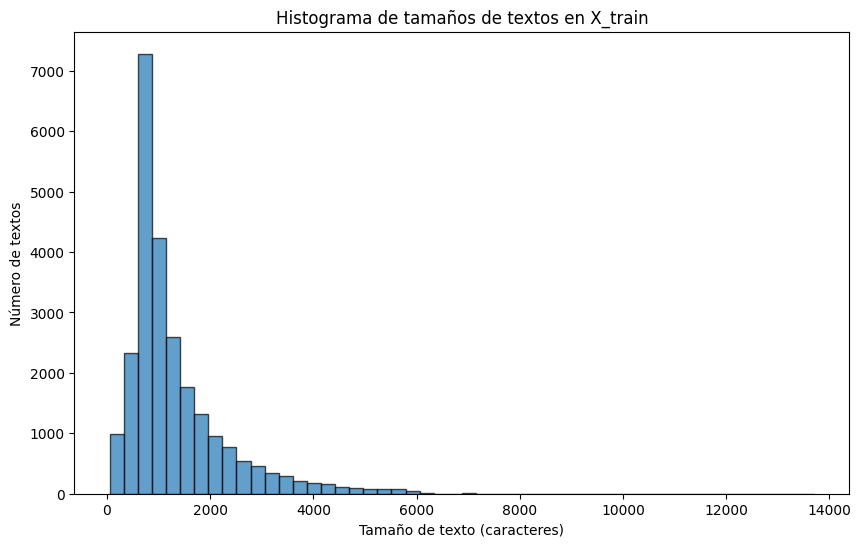

In [18]:
# Histograma de la longitud de los textos de entrenamiento (en caracteres)
sentence_lengths = [len(sentence) for sentence in data]

plt.figure(figsize=(10, 6))
plt.hist(sentence_lengths, bins=50, edgecolor='black', alpha=0.7)
plt.title('Histograma de tamaños de textos en X_train')
plt.xlabel('Tamaño de texto (caracteres)')
plt.ylabel('Número de textos')
plt.show()

## 5. Conjunto de Datos (Dataset)

In [19]:
# Crear el obj dataset
class Imdb_Dataset(Dataset):
  def __init__(self, data, labels, vocab):
        self.data = data
        self.labels = labels
        self.vocab = vocab

        self.text_pipeline = lambda x: self.vocab(tokenizer(x))

  def __len__(self):
      return len(self.data)

  def __getitem__(self, idx):
      text = self.data[idx]
      numerical_text = self.text_pipeline(text)
      label = self.labels[idx]

      return torch.tensor(numerical_text), torch.tensor(label)

In [20]:
# Instanciar Dataset
ds = Imdb_Dataset(data, labels, vocab)

In [21]:
# Observar un dato (tensor de IDs de oración, y tensor con clase)
ds[0]

(tensor([   51,    26,   825,   972,   151,     2,   521,  1111,     4,    26,
            86,   172,     6,   356,  2518,   784,  5244,     3,  1314,  3234,
            10,    62,  1963,     5,  1196,    57,    12,     2,   219,     3,
            32,  5053,   440,     7,   122,   492,    80,    19,     2,  7187,
         22661,    12,  7537,     3,     2,    88,   162,    31,    80,    19,
            73,   525,     3,    13,   126,    29,   172,   107,     7,     2,
           122,  1875,  1204,    48,  2074,     3,     2,   615,    12,   826,
           723,     6,   156, 43378,   158,     4,     5,    13,   585,    51,
            30,    10,   422,     8,    34,     3,    13,    58,    29,   374,
             2,   205,   784,     3,     2,   321,   314,    31,   775,     7,
             2,  4412,     4,    22,    38,   226,    39,    31,    29,  2171,
          1204,    45,    56,     7,     2,  1232,  5330,  2352,    15,    76,
            74,   505,     3,   449,     4,    13,  

In [22]:
# Probar función que mapea indice -> token
ds.vocab.get_itos()[2]

'the'

## 6. Cargador de datos (Dataloader)

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Crear Collate Function (para manejar el padding o truncado)
class MyCollate:
    def __init__(self, pad_value):
        self.pad_value = pad_value

    def __call__(self,batch):
      texts = [item[0] for item in batch]
      texts = pad_sequence(texts, batch_first=True, padding_value=self.pad_value)
      targets = [item[1] for item in batch]
      return texts.to(device), torch.tensor(targets).to(device)

In [24]:
# Insertar el token con el que se hará el padding
pad_value = ds.vocab.get_stoi()['<pad>']

# Instanciar el dataloader
dl = DataLoader(dataset=ds,
                batch_size=32,
                shuffle=False,
                collate_fn=MyCollate(pad_value))

In [25]:
# Ver un ejemplo del dataloader
ex = next(iter(dl))

In [26]:
ex[0].shape

torch.Size([32, 1923])

In [27]:
ex

(tensor([[   51,    26,   825,  ...,     0,     0,     0],
         [   93,  2292,     4,  ...,     0,     0,     0],
         [ 3803, 14096,    10,  ...,     0,     0,     0],
         ...,
         [   14,    21,    17,  ...,     0,     0,     0],
         [ 1207,   212,     3,  ...,     0,     0,     0],
         [   14,    21,    10,  ...,     0,     0,     0]]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1]))

### 6.1 ¿Cómo se generan los vectores densos para la red a partir de un tensor con IDs?

<img src="https://i0.wp.com/clay-atlas.com/wp-content/uploads/2020/07/image-1.png?ssl=1"/>

## 7. Ejercicio: Clase dataset completa

In [28]:
# Ejercicio: Implementa todo el manejo del dataset dentro de la clase

from torch.utils.data import Dataset
# Preprocesar texto:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

# Tokenizamos el texto:
def yield_tokens(data_iter):
  # Creamos el tokenizador para el idioma ingles:
  tokenizer = get_tokenizer("basic_english")
  for text in data_iter:
      yield tokenizer(text)


class Imdb_Dataset(Dataset):
  def __init__(self, data_dir, subset):
        self.data_dir = data_dir
        self.subset = subset
        self.path_pos = self.data_dir+self.subset+'/pos/'
        self.path_neg = self.data_dir+self.subset+'/neg/'

        self.data_pos = []
        self.label_pos = []
        files = [f for f in os.listdir(self.path_pos)]
        for file in files:
            with open(self.path_pos+file, "r", encoding='utf8') as f:
                self.data_pos.append(f.read())
                self.label_pos.append(1)

        self.data_neg = []
        self.label_neg = []
        files = [f for f in os.listdir(self.path_neg)]
        for file in files:
            with open(self.path_neg+file, "r", encoding='utf8') as f:
                self.data_neg.append(f.read())
                self.label_neg.append(0)

        self.data = self.data_pos + self.data_neg
        self.labels = self.label_pos + self.label_neg

        #Creamos vocabulario:
        self.vocab = build_vocab_from_iterator(yield_tokens(self.data), specials=["<pad>","<unk>"])
        self.vocab.set_default_index(vocab["<unk>"])

        self.text_pipeline = lambda x: self.vocab(tokenizer(x))


  def __len__(self):
      return len(self.data)

  def __getitem__(self, idx):
      text = self.data[idx]
      numerical_text = self.text_pipeline(text)
      label = self.labels[idx]

      return torch.tensor(numerical_text), torch.tensor(label)

In [29]:
ds = Imdb_Dataset(DATA_DIR, "train")

In [30]:
ds[0]

(tensor([   51,    26,   825,   972,   151,     2,   521,  1111,     4,    26,
            86,   172,     6,   356,  2518,   784,  5244,     3,  1314,  3234,
            10,    62,  1963,     5,  1196,    57,    12,     2,   219,     3,
            32,  5053,   440,     7,   122,   492,    80,    19,     2,  7187,
         22661,    12,  7537,     3,     2,    88,   162,    31,    80,    19,
            73,   525,     3,    13,   126,    29,   172,   107,     7,     2,
           122,  1875,  1204,    48,  2074,     3,     2,   615,    12,   826,
           723,     6,   156, 43378,   158,     4,     5,    13,   585,    51,
            30,    10,   422,     8,    34,     3,    13,    58,    29,   374,
             2,   205,   784,     3,     2,   321,   314,    31,   775,     7,
             2,  4412,     4,    22,    38,   226,    39,    31,    29,  2171,
          1204,    45,    56,     7,     2,  1232,  5330,  2352,    15,    76,
            74,   505,     3,   449,     4,    13,  